<a href="https://colab.research.google.com/github/YarinBou/RecSys-Matrix-Factorization-Evaluation/blob/main/RecSys-Matrix-Factorization-Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation Systems
## Assignment 1: Matrix Factorization & Evaluation

By: Group 10
Yarin Bouzaglo
Enav sasson
<br><br>

**The goal of this assignment is to:**
- Understand the details of matrix factorization algorithm
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- Please use English language only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a Jupyter notbook.
- The homework needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6+ should be used.  
- You should implement the matrix factorization algorithm by yourself using only basic Python libraries (such as numpy).



<br><br><br><br>

**Grading:**
- Q1 - 0 points - Data exploration
- Q2 - 25 points - Evaluation metrics
- Q3 - 50 points - Models implementation and evaluation
  -  A. Popularity basline model: 10 points
  -  B. Explicit Matrix Factorization: 25 points
  -  C. Train & HyperParams Search: 5 points 
  -  D. Bias only model: 5 points
  -  E. Discussion: 5 points
- Q4 - 25 points - Similarity & Explainability 

`Total: 100`

**Prerequisites**

In [ ]:
!pip install --quiet zipfile36

**Imports**

In [ ]:
# general
import time
import random
import zipfile
import requests
import warnings

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

# metrics - do not use these metrics, but you can use them to check your work
from sklearn.metrics import mean_squared_error,ndcg_score 

# notebook
from IPython.display import FileLink, display

**Hide Warnings**

In [ ]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Set Random Seed**

In [ ]:
random.seed(123)

# Question 1:

## Data exploration 

Download the MovieLens 100K rating dataset.   
Calculate the dataset sparsity, distribution of number of ratings as well as the average rating value per user\item.  
Include additional exploration you find relevant to questions 2 and 3.  
Discuss your insights and possible challenges related to the prediction task described in question 2.  

In [ ]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_name = 'ml-100k.zip'
data_dir = 'ml-100k/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

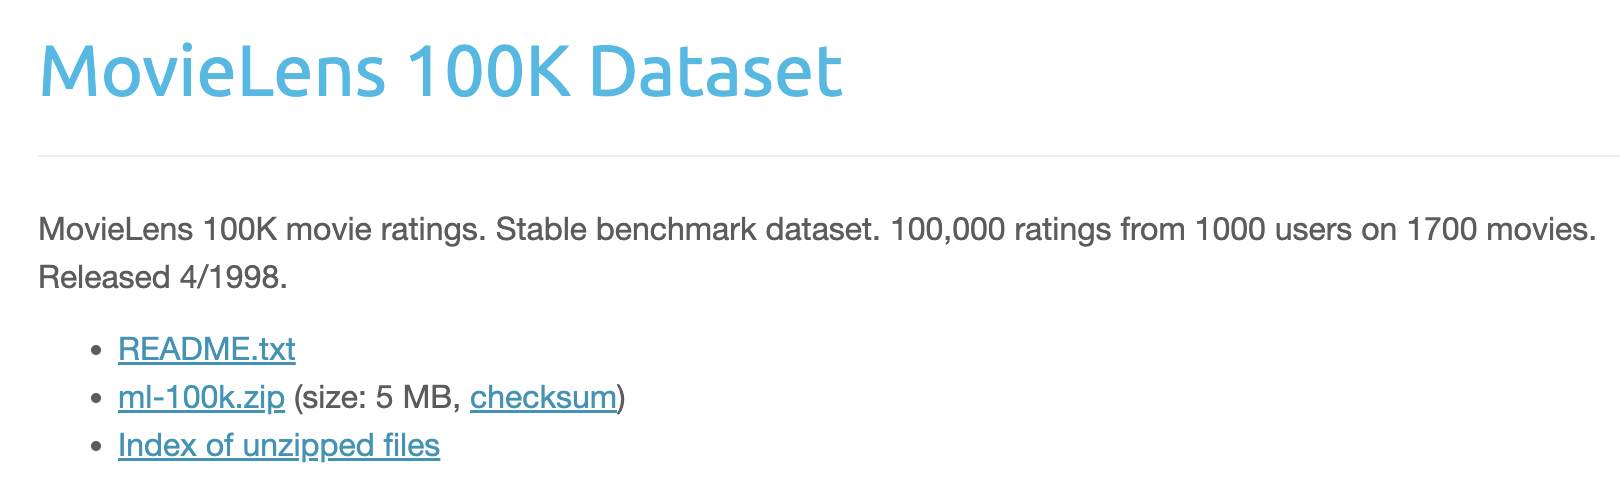

**Columns Names**

In [ ]:
cols_data = ['user_id','item_id','rating','timestamp']
cols_user = ['user_id','age','gender','occupation','zip code']
cols_item = ['movie id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']

**Read users data file**

In [ ]:
df_users = pd.read_csv(data_dir + 'u.user',delimiter='|', header=None,names=cols_user)
df_users.shape

(943, 5)

**Read items(movies) data file**

In [ ]:
df_items = pd.read_csv(data_dir + 'u.item',delimiter='|', header=None,names=cols_item,encoding="ISO-8859-1")
df_items.shape

(1682, 24)

**Read rating data file**

In [ ]:
df_ratings = pd.read_csv(data_dir + 'u.data',delimiter='\t', header=None,names=cols_data)
df_ratings.shape

(100000, 4)

*Making* sure shapes are mathing the info data file

In [ ]:
open(data_dir + 'u.info').readlines()

['943 users\n', '1682 items\n', '100000 ratings\n']

**Matrix:**

In [ ]:
ratings = df_ratings.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
ratings.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br><br><br><br>

**Explore ratings data:**

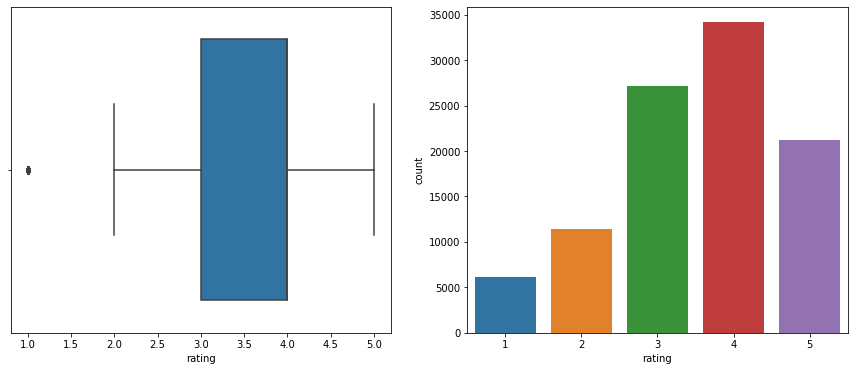

In [ ]:
f, axes = plt.subplots(1, 2,figsize=(15,6))
sns.boxplot(df_ratings.rating,ax=axes[0])
sns.countplot(df_ratings.rating,ax=axes[1])
plt.show()

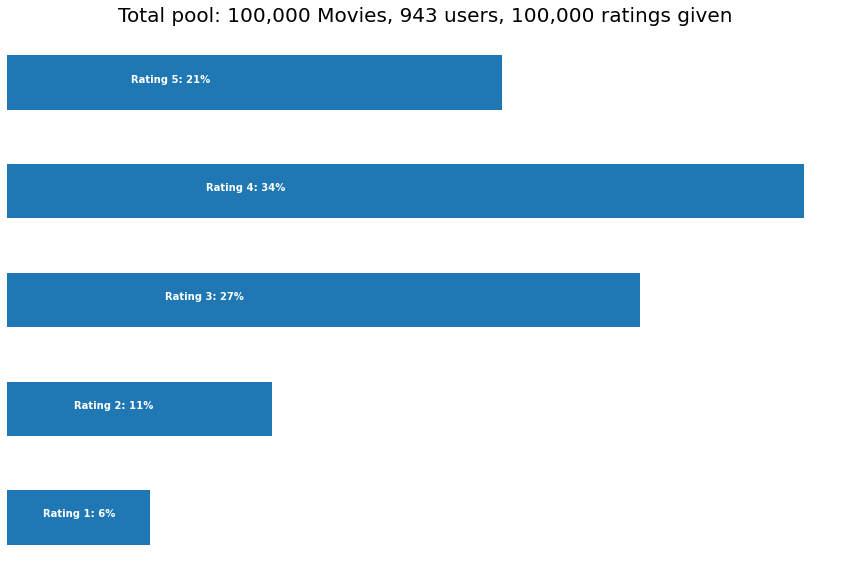

In [ ]:
p = df_ratings.groupby('rating')['rating'].agg(['count'])
movie_count = df_ratings.item_id.count()
cust_count = df_ratings.user_id.nunique() 
rating_count = df_ratings.user_id.count()

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} users, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

**Distribution of number of ratings per user\item**

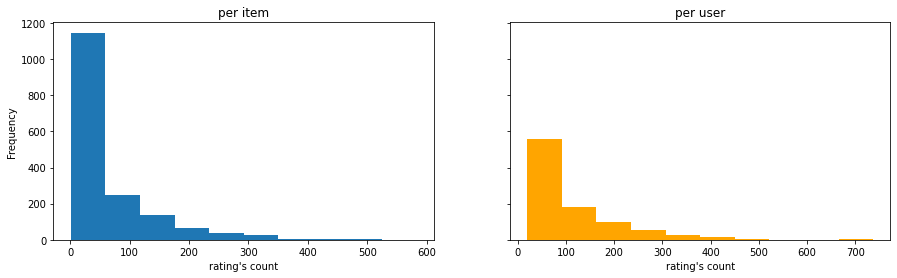

In [ ]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.astype(bool).sum(axis=0).plot.hist(ax=ax[0])
ratings.astype(bool).sum(axis=1).plot.hist(ax=ax[1],color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('rating\'s count')
ax[1].set_xlabel('rating\'s count');

**Distribution of average rating value  per user\item**

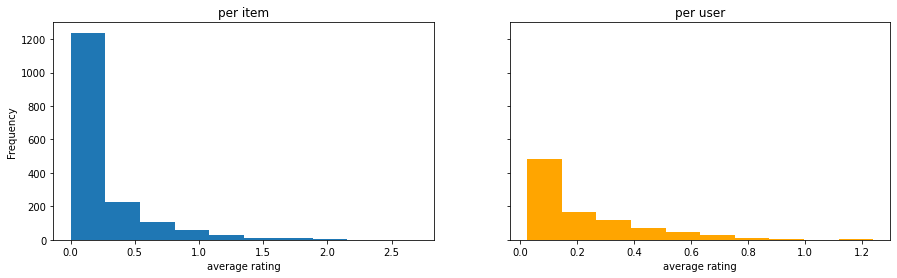

In [ ]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.mean(axis=0).plot.hist(ax=ax[0])
ratings.mean(axis=1).plot.hist(ax=ax[1],color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('average rating')
ax[1].set_xlabel('average rating');

**Movie ratings aggregated by user**

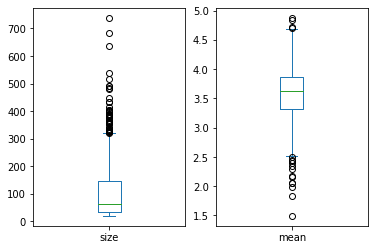

In [ ]:
userRatingsAggr = df_ratings.groupby(['user_id']).agg({'rating': [np.size, np.mean]})
userRatingsAggr.reset_index(inplace=True)  # To reset multilevel (pivot-like) index
userRatingsAggr['rating'].plot(kind='box', subplots=True)
plt.show();

**Genres**

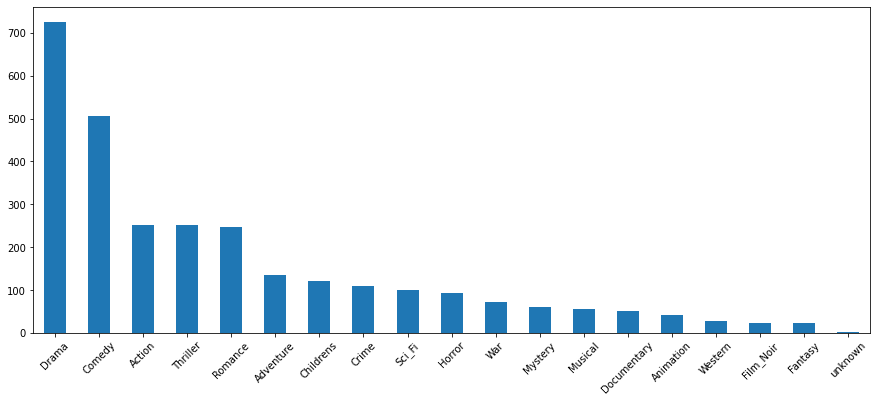

In [ ]:
plt.figure(figsize=(15,6))
df_items.iloc[:,5:].sum().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=45)
plt.show();

**Calculate the dataset sparsity:**

$$
Density  = \frac{\text{number of nonzero ratings in the matrix}}{\text{number of users}\times\text{number of items}} 
\quad \qquad
Sparsity = 1 - \frac{\text{number of nonzero ratings in the matrix}}{\text{number of users}\times\text{number of items}}
$$

In [ ]:
matrix_sparsity =  round((1-np.count_nonzero(ratings)/ratings.size)*100,2)
print('Sparsity is equal to {}%'.format(str(matrix_sparsity)) )

Sparsity is equal to 93.7%


In [ ]:
matrix_density =  round((np.count_nonzero(ratings)/ratings.size)*100,2)
print('Density is equal to {}%'.format(str(matrix_density)) )

Density is equal to 6.3%


<br><br><br><br><br><br>

# Question 2:


## Evaluation Metrics

Please create a class to calculate the following metrics on two different dataset (df_true,df_pred):
- RMSE
- MRR
- nDCG

**Notes:**
- Please read this great blog post: 
<a href='https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832'>MRR vs MAP vs NDCG: Rank-Aware Evaluation Metrics And When To Use Them </a>
- Please consider edge cases - NaN, Null, Zeros, out of bound, eval time, etc.
- You can work with Dataframe or with Numpy arrays(matrix)
- You may remove/add params to these functions
- Please use only pytonic code!

In [ ]:
class my_metrics:
    
    def RMSE(df_true, df_pred, lower_bound=1, upper_bound=5):
      # Convert input data to NumPy arrays if necessary
      if isinstance(df_true, np.ndarray):
          np_true = df_true
      else:
          np_true = df_true.to_numpy()
      if isinstance(df_pred, np.ndarray):
          np_pred = df_pred
      else:
          np_pred = df_pred.to_numpy()

      # Filter out entries where the true value is equal to 0.0
      pred = np_pred[np_true.nonzero()].flatten()
      actual = np_true[np_true.nonzero()].flatten()

      # Calculate and return the RMSE value
      return np.sqrt(np.mean(np.power(pred - actual, 2)))

    def MRR_for_user(user_true, user_pred, lower_bound=1, upper_bound=5, top_n=5, threshold=3):
      cur_rr = 0.0
      cnt, j = 1, len(user_pred) - 1
      # Sort the ratings of the user
      index = np.argsort(user_pred)
      # Iterate over the sorted ratings and stop when we reach a relevant item
      # (rating > mrr_threshold) or we have considered all top_n items
      while j >= 0 and user_true[index[j]] < threshold and cnt <= top_n:
          if user_true[index[j]] != 0:
              cnt += 1
          j -= 1
      # Calculate and return the MRR value for the user
      if j != -1:
          cur_rr = 1 / cnt
      return cur_rr



    def MRR(df_true, df_pred, lower_bound=1, upper_bound=5, top_n=5, threshold=3):
      # Convert input data to NumPy arrays if necessary
      if isinstance(df_true, np.ndarray):
          np_true = df_true
      else:
          np_true = df_true.to_numpy()
      if isinstance(df_pred, np.ndarray):
          np_pred = df_pred
      else:
          np_pred = df_pred.to_numpy()

      # Iterate over all users and calculate the MRR for each user
      mrr_sum, zero_cnt, i = 0, 0, 0
      for row in np_pred:
          cur_rr = my_metrics.MRR_for_user(np_true[i], row, top_n=top_n, threshold=threshold)
          mrr_sum += cur_rr
          # Ignore users with no ratings
          if np.all(np_true[i] == 0):
              zero_cnt += 1
          i += 1
      # Calculate and return the overall MRR
      mrr = mrr_sum / (len(np_pred) - zero_cnt)
      return mrr


    def NDCG(df_true, df_pred, lower_bound=1, upper_bound=5, top_n=5):
      # Convert the true and predicted dataframes to numpy arrays if they are not already
      np_true = df_true.to_numpy() if not isinstance(df_true, np.ndarray) else df_true
      np_pred = df_pred.to_numpy() if not isinstance(df_pred, np.ndarray) else df_pred  
      # Initialize variables to store the sum of NDCGs and the count of users with all zero relevance scores
      (ndcg_sum, zero_cnt, i) = (0, 0, 0)
      # Iterate through the rows (users) of the predicted scores
      for row in np_pred:
          if np.all(np_true[i] == 0):
              zero_cnt += 1
          else:
              # Calculate the NDCG for the current user
              cur_ndcg = my_metrics.NDCG_for_user(np_true[i], row, top_n=top_n)
              ndcg_sum += cur_ndcg
          i += 1
      # Calculate the mean NDCG by dividing the sum by the number of users with non-zero relevance scores
      ndcg = ndcg_sum / (len(np_pred) - zero_cnt)
      return ndcg


    def NDCG_for_user(user_true, user_pred, lower_bound=1, upper_bound=5, top_n=5):
      # Get the indices of the user_pred list in sorted order
      index = np.argsort(user_pred)
      top_index = []
      # Find the top-ranked items by traversing the sorted list in reverse order
      (cnt, j) = (0, len(user_pred) - 1)
      while j >= 0 and cnt <= top_n:
          # Only consider items that have non-zero relevance scores
          if user_true[index[j]] != 0:
              top_index.append(index[j])
              cnt += 1
          j -= 1
      # Get the relevance scores of the top-ranked items
      rel = np.take(user_true, top_index)
      dcg = my_metrics.DCG(rel, len(rel))
      sorted_rel = np.sort(rel)[::-1]
      idcg = my_metrics.DCG(sorted_rel, len(sorted_rel))
      # Return the normalized DCG (NDCG)
      return dcg / idcg


    def DCG(rel, n):
      # Check if the input list is empty or None
      if rel is None or len(rel) < 1:
          return 0.0
    
      # Create a vector of logarithmic values starting from 2 to n+2
      log_vec = np.log2(range(2, n + 2))
      
      # Calculate and return the discounted cumulative gain
      return np.sum(rel / log_vec)



    def get_error(df_true, df_pred):
        return {
            'RMSE': my_metrics.RMSE(df_true, df_pred),
            'MRR_5': my_metrics.MRR(df_true, df_pred, top_n=5),
            'MRR_10': my_metrics.MRR(df_true, df_pred, top_n=10),
            'NDCG_5': my_metrics.NDCG(df_true, df_pred, top_n=5),
            'NDCG_10': my_metrics.NDCG(df_true, df_pred, top_n=10),
            }


Checking your evaltuation metrics and performence:

In [ ]:
%time my_metrics.get_error(ratings,ratings)

CPU times: user 444 ms, sys: 1.91 ms, total: 446 ms
Wall time: 447 ms


{'RMSE': 0.0, 'MRR_5': 1.0, 'MRR_10': 1.0, 'NDCG_5': 1.0, 'NDCG_10': 1.0}

<br><br><br><br>

# Question 3

### Models Implementation & Evaluation
Split the data to train and test.  
Implement explicit matrix factorization algorithm to predict the rating a user will provide to an item and recommendation of top N items.   

Use the RMSE, MRR and NDCG metrics (based on Q2 implementation) to evaluate your recommender system. For the MRR and NDCG metrics use cutoff value of 5. Items with a rating of 3 and above are considered as relevant.   

Produce a learning curve graph and a table which compares the results of the following algorithms: 
 - Bias only based model
 - Simple popularity based model
 - Different choices of the latent factor dimension regularization, learning rate. 



**Save final results**

In [ ]:
final_results = pd.DataFrame(columns=['Method','Time','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10'])

**Choose fold**

In [ ]:
df_folds = {i:
       {'train' : pd.read_csv('{}u{}.base'.format(data_dir,i), delimiter='\t', header=None, names=cols_data),
        'test'  : pd.read_csv('{}u{}.test'.format(data_dir,i), delimiter='\t', header=None, names=cols_data)
       } for i in range(1,6)} 

def fold2df(i):
    train = df_folds[i]['train'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    test  = df_folds[i]['test'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    return train,test 

def getfulldf(train_fold,test_fold):
    train = ratings.copy()
    train[:] = 0
    test = train.copy()
    
    train.loc[train_fold.index,train_fold.columns] = train_fold.values
    test.loc[test_fold.index,test_fold.columns] = test_fold.values
    return train,test

fold = 1
train,test = getfulldf(*fold2df(1))

train.shape,test.shape

((943, 1682), (943, 1682))

### A. Popularity model

Recommend the most popular movies which have more than 10 ratings.

Use the RMSE, MRR and NDCG metrics to evaluate your recommender system.   
For the MRR and NDCG metrics use cutoff values of 5 and 10.   

In [ ]:
class POP():

    def __init__(self,df_train,M=10):
    # df is the set to train on
    # N is the number of movies to recommend
    # M is the minimum votes required to be listed in the chart
        self.df_train = df_train
        self.min_movie_ratings = M
        self.recommended = ratings.copy()
        self.recommended[:] = 0
        self.fit_time = 0

      
    def fit(self):
      start = time.time()
      # Count the number of ratings each movie has received
      df_rating_count = self.df_train.astype(bool).sum(axis=0)
      df_irrelevant_movies = df_rating_count[df_rating_count < self.min_movie_ratings]
      movies_list_irrelevant = list(df_irrelevant_movies.index.values)

      # Calculate the mean rating for each movie
      df_train_movies = self.df_train.replace(0.0, np.NaN)
      self.df_train_movies_mean = df_train_movies.mean(axis=0)

      # Set the mean rating for movies with fewer than M ratings to 0
      self.df_train_movies_mean.loc[movies_list_irrelevant] = 0.0
      self.predict()
      stop = time.time()
      self.fit_time = stop - start
    
    def predict(self,N=10):
      for user_index in range(1, self.recommended.shape[0]):
        # Set the recommended movies for the current user to the mean ratings for all movies
        self.recommended.loc[user_index] = self.df_train_movies_mean
    
    def get_rmse(self,test):
      return my_metrics.RMSE(test,self.recommended)
    
    def get_mrr(self,test,k=10,threshold=3):
      return my_metrics.MRR(test,self.recommended,top_n=k,threshold=threshold)
    
    def get_ndcg(self,test,k=5):
      return my_metrics.NDCG(test,self.recommended,top_n=k)

    
    # this is just a quick checking function for you to use while debugging
    def predict_title(self):
        return df_items.set_index('movie id').loc[self.predict()]['movie_title']

Checking your model and performance:

In [ ]:
# create popularity model
model_pop = POP(train)
# train model
%timeit model_pop.fit()
# record model results
final_results.loc[len(final_results)] = 'Popularity', model_pop.fit_time, model_pop.get_rmse(test), model_pop.get_mrr(test,k=5), model_pop.get_mrr(test,k=10), model_pop.get_ndcg(test,k=5), model_pop.get_ndcg(test,k=10)
# display
final_results

357 ms ± 82.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,0.585104,1.139662,0.973312,0.973191,0.959325,0.955111


### B. Explicit Matrix Factorization

**Implement explicit matrix factorization algorithm to predict the rating a user will provide to an item and recommendation of top N items.**

Use the RMSE, MRR and NDCG metrics to evaluate your recommender system.   
For the MRR and NDCG metrics use cutoff values of 5 and 10.   

In [ ]:
class MF():
    
    def __init__(self,df_train,n_factors=10,only_bias=False):
        self.df_train = df_train
        self.n_factors = n_factors
        self.only_bias = only_bias
        
        # rows==users , cols==items
        self.n_rows, self.n_cols = df_train.shape
        
        # biases
        self.original_bias_global = np.sum(df_train)/np.count_nonzero(df_train)
        self.original_bias_rows   = np.sum(df_train,axis=1)/np.count_nonzero(df_train,axis=1) 
        self.original_bias_cols   = np.sum(df_train,axis=0)/np.count_nonzero(df_train,axis=0)
        
        # "reset" initialization 
        self.initialize_params()

        # count only the none-zeros cells.
        self.sample_row, self.sample_col = self.df_train.nonzero()
        self.n_samples = len(self.sample_row)
        
    def initialize_params(self):
      if not self.only_bias:
          self.user_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_rows, self.n_factors))
          self.item_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_cols, self.n_factors))

      # Initialize biases
      self.bias_global = self.original_bias_global  # No need to learn it
      self.bias_rows = np.random.rand(self.n_rows)  # Random
      self.bias_cols = np.random.rand(self.n_cols)  # Random         
      
    def fit(self,
        n_iterations=1,
        learning_rate=1e-1,
        regularization=1e-2,
        convergence=1e-5,
        error='RMSE',
        initialize_training=True,
        verbose=True):

        self.n_iterations = n_iterations
        self.α = learning_rate
        self.λ = regularization
        self.ϵ = convergence
        self.error = error

        if initialize_training:
            self.initialize_params()

        # Initialize the history list to record the progress
        self.history = []

        # Record the training time
        self.fit_time = None
        start = time.time()

        # Add the first record to history before starting training
        predictions = self.predict()
        if self.error == 'RMSE':
            self.history += [self.get_rmse(self.df_train, predictions)]
        else:
            self.history += [self.get_mrr(self.df_train, predictions)]

        # Train in iterations
        for current_iteration in range(self.n_iterations):
            # Print iteration status
            if verbose:
                print('Iteration: ', current_iteration, ' Total error:\n', self.history[-1])

            self.training_indices = np.arange(self.n_samples)
            np.random.shuffle(self.training_indices)
            # Update parameters
            self.optim_GD()

            # Compute the cost function
            predictions = self.predict()

            # Record the cost in every iteration
            if error == 'RMSE':
                self.history += [self.get_rmse(self.df_train, predictions)]
            else:
                self.history += [self.get_mrr(self.df_train, predictions)]

            # Check for convergence
            if current_iteration != 0 and self.is_converging(current_iteration):
                if verbose:
                    print('Converged...')
                break

        # Update training time after finishing
        stop = time.time()
        self.fit_time = stop - start

    def is_converging(self, current_iteration):
      if current_iteration + 1 >= len(self.history):
          return False
      return self.history[current_iteration] - self.history[current_iteration+1] < self.ϵ

    def optim_GD(self):
    # Iterate over all training samples
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict_single_rec(u, i)

            # Calculate error between prediction and actual rating
            e = self.df_train[u,i] - prediction

            # Skip updating latent factors if only_bias flag is set
            if not self.only_bias:
                # Update latent factors for user and item
                self.user_vecs[u, :] += self.α * (e * self.item_vecs[i, :] - self.λ * self.user_vecs[u,:])
                self.item_vecs[i, :] += self.α * (e * self.user_vecs[u, :] - self.λ * self.item_vecs[i,:])

                # Clip latent factors to a range of [-5, 5] to prevent divergence
                self.user_vecs[u, :] = np.clip(self.user_vecs[u, :], -5, 5)
                self.item_vecs[i, :] = np.clip(self.item_vecs[i, :], -5, 5)

            # Update biases for user and item
            self.bias_rows[u] += self.α * (e - self.λ * self.bias_rows[u])
            self.bias_cols[i] += self.α * (e - self.λ * self.bias_cols[i])    

    def predict_single_rec(self, u, i):
      # predict recommendation for one user and one item 
      prediction = self.bias_global + self.bias_rows[u] + self.bias_cols[i]
      if self.only_bias:
        pass
      else:
        prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
      return prediction
        
    def predict(self,N=10):
      """ Predict ratings for every user and item."""
      if self.only_bias:
        predictions = np.zeros((self.n_rows, 
                        self.n_cols))
      else:
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
      for u in range(self.n_rows):
          for i in range(self.n_cols):
              predictions[u, i] = self.predict_single_rec(u, i)
      return predictions
      
    def get_rmse(self,actual,pred):
      return my_metrics.RMSE(actual,pred)

    def get_mrr(self,actual,pred,k=10,threshold=3):
      return my_metrics.MRR(actual,pred,top_n=k,threshold=threshold)    
    
    def get_ndcg(self,actual,pred,k=5):
      return my_metrics.NDCG(actual,pred,top_n=k)

Checking your model and performance:

In [ ]:
# create MF model
model_mf = MF(train.values,n_factors=5,only_bias=False)

# train model
%time model_mf.fit(n_iterations=2,verbose=False,regularization=0.01,convergence=1e-100,learning_rate=0.1)

# record model results
final_results.loc[len(final_results)] = 'MF', model_mf.fit_time, model_mf.get_rmse(test,model_mf.predict()), model_mf.get_mrr(test,model_mf.predict(),k=5), model_mf.get_mrr(test,model_mf.predict(),k=10), model_mf.get_ndcg(test,model_mf.predict(),k=5), model_mf.get_ndcg(test,model_mf.predict(),k=10)

# display
final_results

CPU times: user 19.2 s, sys: 515 ms, total: 19.7 s
Wall time: 19.2 s


,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,0.585104,1.139662,0.973312,0.973191,0.959325,0.955111
1,MF,19.239509,59.122120,0.902288,0.902197,0.925907,0.917905


<br><br><br>

## C. Train & HyperParams Search 


**Different choices of the latent factor dimension, regularization, learning rate.**

and Find best hyperparameters


While running of these permutations:

    - n_iterations   = [20]     
    - convergence    = [1e-5]    
    - latent_factors = [5,10,20]    
    - regularization = [0.01,0.1,1]    
    - learning_rate  = [0.001,0.01,0.1]    



In [ ]:
def find_best_params(only_bias=False):

  n_iterations   = [20] # just one value due to computational power
  convergence    = [1e-5,1e-3]  
  latent_factors = [5, 10, 20]
  regularization = [0.01, 0.1, 1]
  learning_rate  = [0.001, 0.01, 0.1]

  results = pd.DataFrame(columns=['Latent_factors','Iterations','Learning_Rate','Regularization','Convergence','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','History','Time'])

  for n_iter in n_iterations:
      for lf in latent_factors:
          for lr in learning_rate:
              for reg in regularization:
                  for conv in convergence:

                      dic = {'Iterations':n_iter,'Latent_factors':lf,'Learning_Rate':lr,'Regularization':reg,'Convergence':conv}

                      # initialize model
                      mf = MF(train.values,n_factors=lf)
                      
                      # record training time
                      start = time.time()
                      
                      # train MF
                      mf.fit(verbose=False,n_iterations=n_iter,regularization=reg,convergence=conv,learning_rate=lr)
                                            
                      # record traning time
                      dic['Time'] = time.time() - start
                      
                      # eval model
                      # please use the model evaluation funcntions
                      dic['RMSE'] = mf.get_rmse(test,mf.predict())
                      dic['MRR_5'] = mf.get_mrr(test,mf.predict(),k=5)
                      dic['MRR_10'] = mf.get_mrr(test,mf.predict(),k=10)
                      dic['NDCG_5'] = mf.get_ndcg(test,mf.predict(),k=5)
                      dic['NDCG_10'] = mf.get_ndcg(test,mf.predict(),k=10)
                  
                      # record model history
                      dic['History'] = mf.history 
                      
                      # add experiment
                      results = results.append(dic,ignore_index=True)
  return results

**Training history:**

In [ ]:
results = find_best_params()
results

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time
0,5,20,0.001,0.01,0.00001,1.021072,0.961220,0.961055,0.954603,0.949783,"[1.5523537111137464, 1.3634462545267745, 1.251...",166.937363
1,5,20,0.001,0.01,0.00100,1.023234,0.964052,0.963887,0.953728,0.949519,"[1.5635420145064547, 1.3689864870995245, 1.254...",162.571363
2,5,20,0.001,0.10,0.00001,1.019659,0.960857,0.960692,0.952785,0.948962,"[1.5490388892072569, 1.3571915470123546, 1.245...",164.922976
3,5,20,0.001,0.10,0.00100,1.019232,0.954866,0.954701,0.951591,0.948059,"[1.5695917277214453, 1.369236486586809, 1.2523...",162.147065
4,5,20,0.001,1.00,0.00001,1.044123,0.931990,0.931734,0.941363,0.939264,"[1.5314864926646778, 1.303801994944636, 1.1991...",166.484465
5,5,20,0.001,1.00,0.00100,1.045778,0.934096,0.933766,0.941503,0.938417,"[1.563782289817318, 1.3225716667990781, 1.2112...",168.947781
6,5,20,0.010,0.01,0.00001,0.970311,0.978940,0.978775,0.961259,0.956068,"[1.5470431486732816, 1.0226965394456102, 0.968...",160.548383
7,5,20,0.010,0.01,0.00100,0.960555,0.976035,0.976035,0.960331,0.957313,"[1.5610644441412098, 1.0245156929984125, 0.968...",165.688543
8,5,20,0.010,0.10,0.00001,0.949141,0.967683,0.967518,0.959028,0.955417,"[1.5606312173548744, 1.0223812571220425, 0.969...",162.772072
9,5,20,0.010,0.10,0.00100,0.949908,0.965323,0.965158,0.959172,0.955487,"[1.5739621820604828, 1.0229997069993535, 0.970...",165.178612


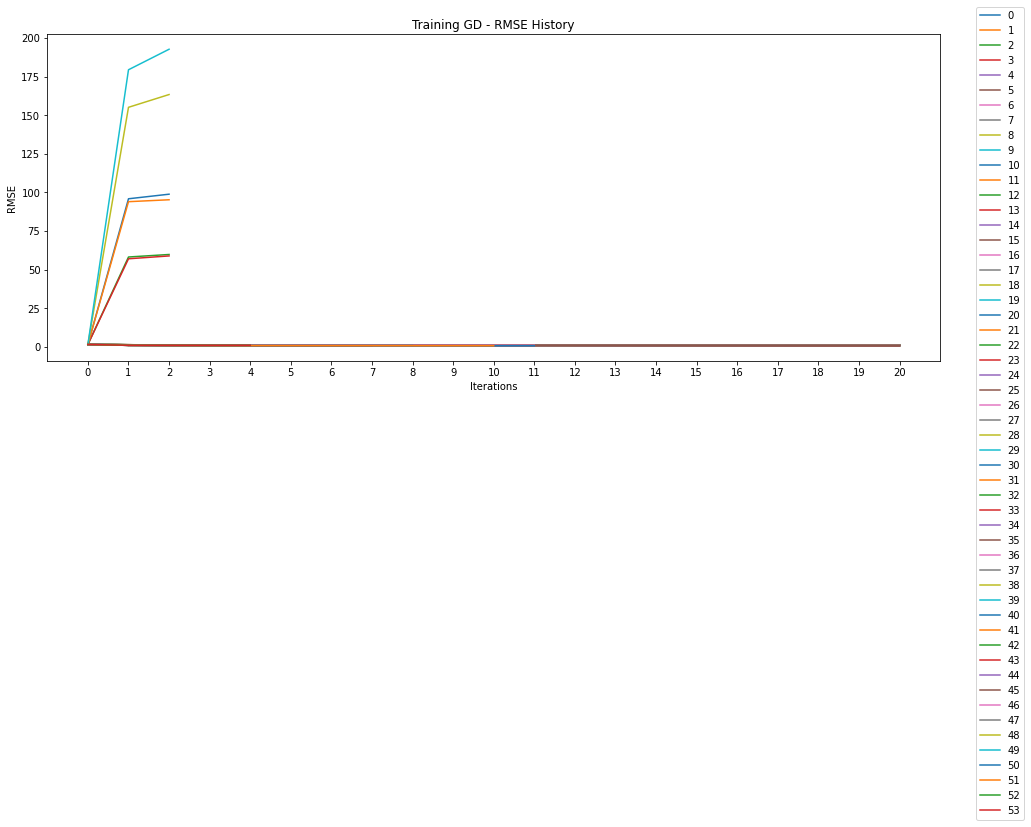

In [ ]:
n_iterations   = [20]
lines = results.History

plt.figure(figsize=(16,6))

for l in lines:
    plt.plot(l)

plt.xticks(np.arange(n_iterations[0]+1))
plt.legend(lines.index,loc='upper right',bbox_to_anchor=(1.1, 1.1))
plt.title('Training GD - RMSE History')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.show();

**Focus on the top 3:**

In [ ]:
results.loc[results.RMSE.nsmallest(3).index,:]

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time
27,10,20,0.01,0.10,0.001,0.946707,0.969862,0.969697,0.960983,0.957355,"[1.5546373713126287, 1.022607024885449, 0.9711...",163.940650
43,20,20,0.01,0.01,0.001,0.947977,0.978577,0.978577,0.962559,0.959292,"[1.5503159193349965, 1.0216809677502265, 0.969...",161.235298
45,20,20,0.01,0.10,0.001,0.948056,0.971496,0.971331,0.960526,0.956594,"[1.5625373003767953, 1.0246188985358196, 0.972...",160.300703


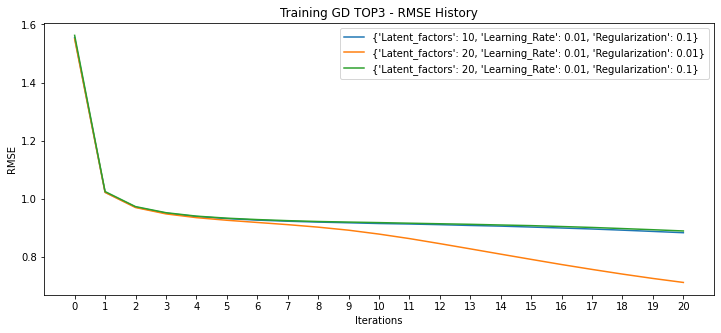

In [ ]:
lines = lines[results.RMSE.nsmallest(3).index]
plt.figure(figsize=(12,5))

for l in lines:
    plt.plot(l)

plt.xticks(np.arange(n_iterations[0]+1))

leg = (results.loc[results.RMSE.nsmallest(3).index,['Latent_factors','Learning_Rate','Regularization']]).T.to_dict().values()
plt.xticks(np.arange(n_iterations[0]+1))
plt.title('Training GD TOP3 - RMSE History')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend(leg)
plt.show();

**Q: is there a clear winner?**

Based on the RMSE, NDCG, and MRR metrics, the performance of the three models is comparable and the differences between them are not statistically significant. As a result, there is no model that stands out as a clear winner.
but maybe the Popularity model for our purpose do a good job with not a lot of computing time.






Please add your winner to `final_results` dataframe.

In [ ]:
# Record top 3 model results
top_3 = results.loc[results.RMSE.nsmallest(3).index, :].reset_index()
final_results.loc[len(final_results)] = ['MF winner', model_mf.fit_time, *top_3.loc[0, ['RMSE', 'MRR_5', 'MRR_10', 'NDCG_5', 'NDCG_10']]]

# Display final results
final_results

,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,0.585104,1.139662,0.973312,0.973191,0.959325,0.955111
1,MF,19.239509,59.122120,0.902288,0.902197,0.925907,0.917905
2,MF winner,19.239509,0.946707,0.969862,0.969697,0.960983,0.957355


**Understanding The Effect - `Latent Factors` - Your Conclusions:**

The model with the smallest latent factor achieved the third best result. When examining the full results table, it appears that increasing the latent factor did not improve the performance. It is therefore possible to learn user preferences using a vector of size five rather than a larger one, which would be more efficient in terms of latency and memory usage. As a result, it is better to use smaller latent factors in this case.

**Understanding The Effect - `Learning Rate` - Your Conclusions:**


The RMSE metric shows that a learning rate of 0.001 takes too long to converge (over 20 iterations) compared to a learning rate of 0.01. On the other hand, a learning rate of 0.1 causes divergence.

**Understanding The Effect - `Regularization` - Your Conclusions:**

Increasing the regularization to 1.0 significantly decreases performance because the model is likely underfitting the data and unable to learn a useful function due to the high regularization. On the other hand, a regularization of 0.01 slightly increase performance compared to 0.1 in terms of MRR and MDCG.

<br><br><br>

## D. Bias only based model
#### Repeat the explicit matrix factorization implementation for the bias only model. Please use the same visualizations.  

<br>

**Hyperparams search + train the model :**

In [ ]:
result_bias_only = find_best_params(only_bias=True)

**Choose your top3 models:**


In [ ]:
result_bias_only.loc[result_bias_only.RMSE.nsmallest(3).index,:]

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time
26,10,20,0.01,0.1,0.00001,0.947809,0.975672,0.975507,0.961953,0.957484,"[1.564486749099245, 1.0230821978175264, 0.9714...",163.723802
27,10,20,0.01,0.1,0.00100,0.947924,0.973312,0.973146,0.961818,0.957753,"[1.5434613055867241, 1.0205384651850147, 0.969...",162.672854
45,20,20,0.01,0.1,0.00100,0.948330,0.972767,0.972602,0.960731,0.957009,"[1.5504065543470615, 1.0231173438636678, 0.971...",165.608228


**Add your winner to `final_resuls` dataframe:**

In [ ]:
# record model results
top = result_bias_only.loc[result_bias_only.RMSE.nsmallest(3).index,:].reset_index()
final_results.loc[len(final_results)] = 'MF only bias winner', top.loc[0]['Time'], top.loc[0]['RMSE'], top.loc[0]['MRR_5'], top.loc[0]['MRR_10'], top.loc[0]['NDCG_5'], top.loc[0]['NDCG_10']

# display
final_results

,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,0.585104,1.139662,0.973312,0.973191,0.959325,0.955111
1,MF,19.239509,59.122120,0.902288,0.902197,0.925907,0.917905
2,MF winner,19.239509,0.946707,0.969862,0.969697,0.960983,0.957355
3,MF only bias winner,163.723802,0.947809,0.975672,0.975507,0.961953,0.957484


<br><br>
**Different Methos - Conclude Final Results**

In [ ]:
final_results.columns

Index(['Method', 'Time', 'RMSE', 'MRR_5', 'MRR_10', 'NDCG_5', 'NDCG_10'], dtype='object')

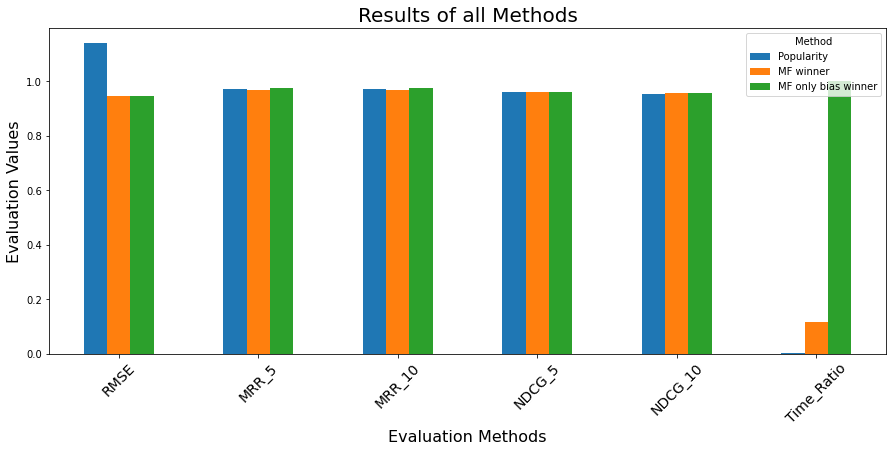

,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Time_Ratio
Method,,,,,,
Popularity,1.139662,0.973312,0.973191,0.959325,0.955111,0.003574
MF winner,0.946707,0.969862,0.969697,0.960983,0.957355,0.117512
MF only bias winner,0.947809,0.975672,0.975507,0.961953,0.957484,1.000000


In [ ]:
final_results = final_results.set_index('Method')
final_results['Time_Ratio'] = final_results['Time']/final_results['Time'].max()
final_results.drop(['Time'], axis=1,inplace=True)
final_results.drop('MF',inplace=True)

final_results.T.plot(kind="bar", figsize=(15,6))
plt.title("Results of all Methods", fontsize=20)
plt.xlabel("Evaluation Methods", fontsize=16)
plt.ylabel("Evaluation Values", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.show();

final_results

**Understand `only-Bias-model` VS `full-model` - Your Conclusions:**  
- Based on the results shown, it appears that the "MF winner" model (which is a full model) has slightly better performance than the "only bias" model in terms of all metrics except popularity, where the "only bias" model performs slightly better.
- Additionally, both the full model and the only-bias model perform significantly better than the "popularity" baseline, which suggests that using additional factors beyond just popularity (such as user and item latent vectors) can improve the recommendation performance.
- Overall, these results suggest that full models may be a better choice for this particular problem, as they are able to learn more complex relationships and achieve better performance compared to only-bias models.




<br><br><br><br><br><br><br>

## E. Discussion 

Describe your challenges and findings, including comparison between the algorithms as well as your recommendations for how to select the latent factor dimension, the contribution of regularization and pros\cons of the different algorithms.

In your comparison refer to the evaluation metrics, training and inference duration, learning convergence and additional aspects you find relevant.

`popularity bias:` Please refers to system recommends the movies with the most interactions without any personalization

`item cold-start problem:` Please refers to when movies added to the catalogue have either none or very little interactions while recommender rely on the movie’s interactions to make recommendations

`scalability issue:` Please refers to lack of the ability to scale to much larger sets of data when more and more users and movies added into our database

We encountered some challenges while working on this assignment, such as divergence.
We solved this problem by implementing gradient clipping.

After comparing the three algorithms (Popularity, MF, and MF only bias), we found that their performance was similar according to all metrics. As a result, we conclude that the Popularity model is the best choice for this dataset in terms of latency and memory efficiency.

`MRR VS nDCG`

**MRR**  
`Pros:`   
    -  Easier to compute and interpret compared to other rank-aware metrics like NDCG.
    -   Simple to understand how it is calculated. 

`Cons:`    
    -   Only considers the first relevant item in the list, and not the entire list. This may not be suitable for tasks like movie recommendation lists where the entire list is important.
    -  Based on binary relevance, so it does not take into account different levels of relevancy. 

**NDCG**  
`Pros:`  
    -   Considers the entire list, not just the first relevant item, which makes it a better fit for tasks like movie recommendation lists.
    -   Takes into account different levels of relevancy, which can be useful when the data includes this information.

`Cons:`  
    -   Requires handling issues like missing user ratings and users with no ratings, which can lead to IDCG being zero. This can add complexity to the implementation.

<br><br><br><br>

# Question 4: 


## Item similarity & explainability 
a)	Suggest a method to find similarity between items. Demonstrate the approach on a set of 5 item pairs of your choice based on item representation by your best matrix factorization model. Leverage the items side information available in the dataset to demonstrate the effectiveness of the suggested approach. 

b)	Select two latent dimensions of your matrix factorization model and try to estimate the latent ‘meaning’ of the learnt matrix factorization model. Demonstrate your estimation, using few items from the dataset and the items side information available in the dataset and\or external information. 


**Find similarity between items and demonstrate the approach on a set of 3 item triplets of your choice based on item representation by your one of your top3 matrix factorization model.**
  
**Leverage the items side information available in the dataset to demonstrate the effectiveness of the suggested approach.**

In [ ]:
model = MF(train.values,n_factors=10)
model.fit(verbose=False,n_iterations=20,regularization=0.1,convergence=0.00001,learning_rate=0.01)
item_matrix = model.item_vecs

**Known methods to find similarity between items are:**
- Pearson Corellation  
- Cosine Similarity 
- Mean Difference
- L2 Distance

**Please implement them using numpy package:** 
(for example: np.linalg)


In [ ]:
import numpy as np

def get_item2vec(mf, i):
    return mf[i]

def get_pearson_similarity(a, b):
    return np.corrcoef(a, b)[0][1]

def get_cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def get_mean_diff_similarity(a1, a2):
    return np.mean(a1) - np.mean(a2)

def get_l2_similarity(a1, a2):
    return np.linalg.norm(a1 - a2)


**For the next step, please choose your favorite method.**  

**Please compare 3 triplets of movies, and for each triplet create this:**   
Create a dataframe same as the example

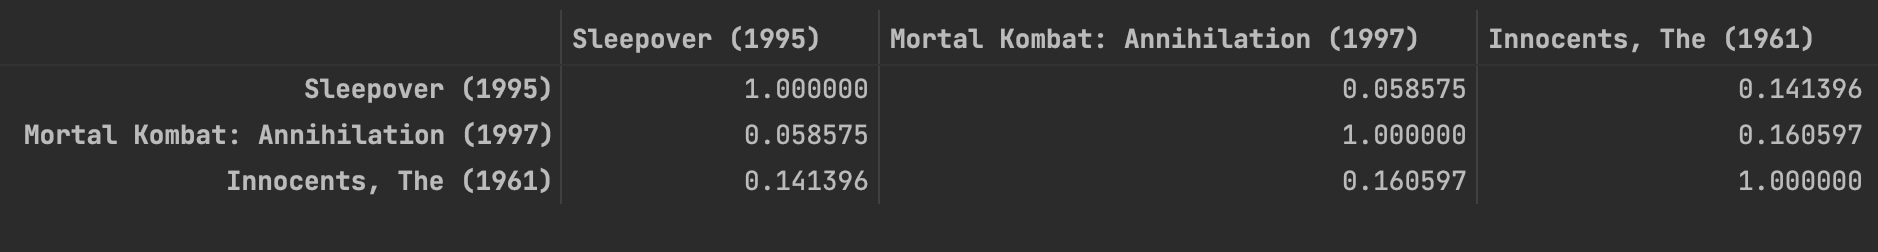

In [ ]:
def get_movie_table(idx1, idx2, idx3):
    # Get the movie titles for the given movie indices
    movie_list = [df_items.loc[idx1]['movie_title'], df_items.loc[idx2]['movie_title'], df_items.loc[idx3]['movie_title']]
    movie_index_list = [idx1, idx2, idx3]
    movies_table = pd.DataFrame(columns=movie_list, index=movie_list)
    # Iterate over the movie list
    for i in range(len(movie_list)):
        row = []
        # Calculate the Pearson similarity between each pair of movies
        for j in range(len(movie_list)):
            pears_sim = get_pearson_similarity(get_item2vec(item_matrix, movie_index_list[i]), get_item2vec(item_matrix, movie_index_list[j]))
            row.append(pears_sim)
        # Add the row of similarity values to the DataFrame
        movies_table.loc[movie_list[i]] = row
    return movies_table


**First Triplet:**

In [ ]:
get_movie_table(10,20,30)

,Seven (Se7en) (1995),Muppet Treasure Island (1996),Crimson Tide (1995)
Seven (Se7en) (1995),1.0,0.050922,0.119827
Muppet Treasure Island (1996),0.050922,1.0,0.316821
Crimson Tide (1995),0.119827,0.316821,1.0


**Second Triplet:**

In [ ]:
get_movie_table(100,500,600)

,Heavy Metal (1981),Dumbo (1941),For Whom the Bell Tolls (1943)
Heavy Metal (1981),1.0,-0.46993,-0.201556
Dumbo (1941),-0.46993,1.0,0.207255
For Whom the Bell Tolls (1943),-0.201556,0.207255,1.0


**Third Triplet**

In [ ]:
get_movie_table(45,123,851)

,Exotica (1994),Lone Star (1996),"Bloody Child, The (1996)"
Exotica (1994),1.0,0.419548,-0.564107
Lone Star (1996),0.419548,1.0,-0.473402
"Bloody Child, The (1996)",-0.564107,-0.473402,1.0


<br><br><br>
**Find two latent dimensions of your matrix factorization model and try to estimate the latent ‘meaning’ of the learnt matrix factorization model.**

**Tip:**  
would we get a good seperation for different genres?  
For example, here we can see that this is not a good seperation.




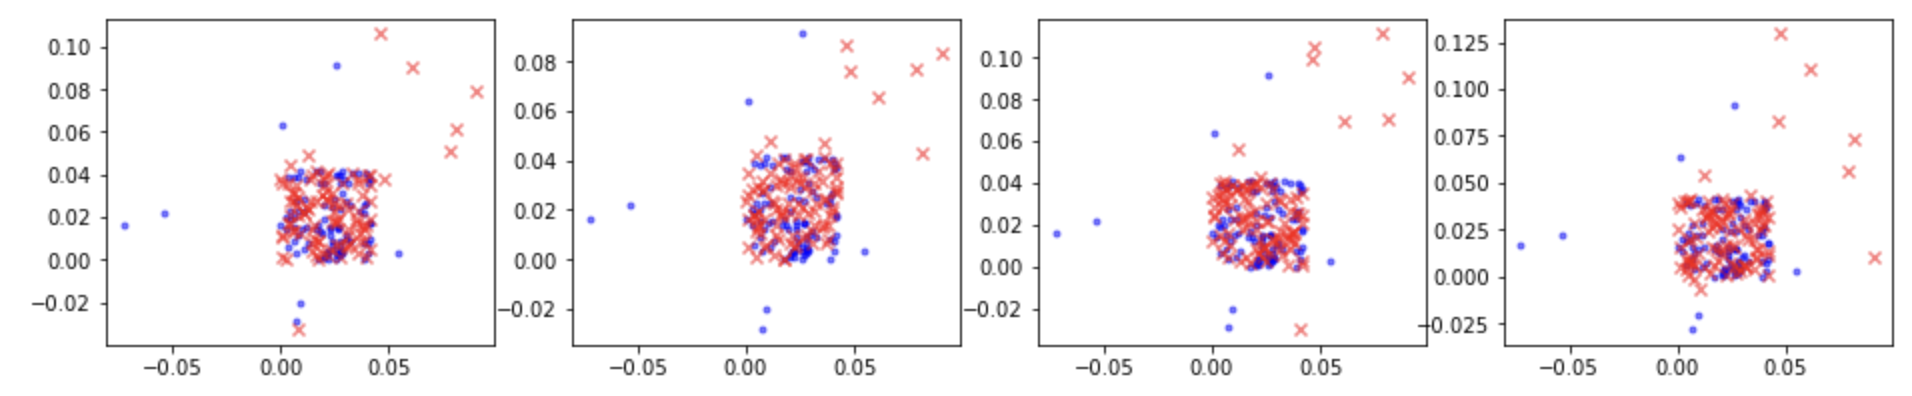

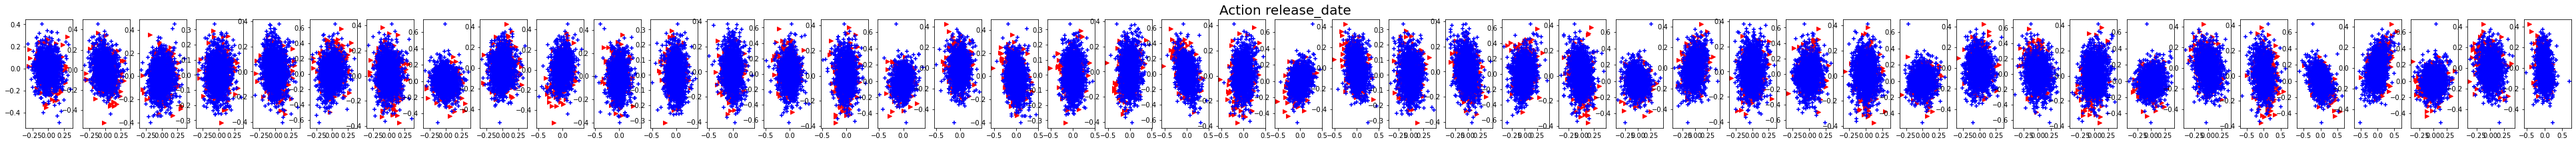

In [ ]:
# Define testing features
feature_1  = 'Action'
feature_2 = 'release_date'

idx_list_feature = list(df_items[df_items.Action>0].index)
idx_list_non_feature = list(df_items[df_items.Action < 1 ].index)

fig = plt.figure()
fig.set_size_inches(70,3)
fig.suptitle(feature_1 + ' ' + feature_2,fontsize=20)
plot_idx = 1

# Loop through all combinations of latent dimensions
for i in range(item_matrix.shape[1]):
  for j in range(i+1,item_matrix.shape[1]):
    x = item_matrix.T[i]
    y = item_matrix.T[j]

    # Extract values for items with and without feature 1
    x_feature = np.take(x, idx_list_feature)
    y_feature = np.take(y, idx_list_feature)
    x_non_feature = np.take(x, idx_list_non_feature)
    y_non_feature = np.take(y, idx_list_non_feature)

    # Create a subplot for each combination of latent dimensions
    plt.subplot(1, 46, plot_idx)
    plt.scatter(x_feature, y_feature, color='r',marker='>')
    plt.scatter(x_non_feature, y_non_feature, color='b',marker='+')
    plot_idx += 1
plt.show()

This section describes a study in which all combinations of two latent dimensions (features that are not directly observable but can be inferred) were analyzed. Two approaches were used to separate the latent dimensions: (1) combining genres (e.g., only action movies or action-drama movies) with release dates, and (2) another approach. It was found that the first approach did not result in a good separation of the items, suggesting that the latent meaning is more complex than just a single genre or combination of genres.